# Lab 07 -- More NN

Note I have added the solution to the exercise at the bottom of the lab.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Goals for the lab
- Repeat the logistic regression exercise but add tensorflow logging
- Save the model weights
- Add a hidden layer to the net

In [32]:
import tensorflow as tf
import numpy as np
import os

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
# The %run command executes a python file as if it was a cell in the notebook. 
%run plot_images.py

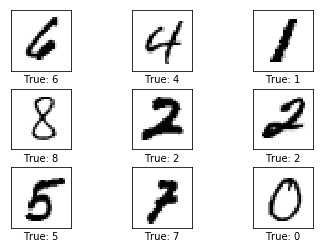

In [5]:
x_batch, y_batch = data.train.next_batch(9)
plot_images(x_batch, y_batch.argmax(1))

# Set up a net to estimate/predict digits

In [6]:
#hyperparameters
num_inputs = 28*28
num_outputs = 10

In [7]:
tf.reset_default_graph()

Input placeholders for the data `x` and the expected (1hot) labels `y`.

In [8]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, 28*28), name='x')
    y = tf.placeholder(tf.float32, (None, 10), name='y')
    ec = tf.argmax(y, 1, name='ec') #[e]xpected [c]lass label
  
    # When this node is run, it will save an image to a log file.
    #  - I am not assigning a variable to the result;,
    #    all of the summary nodes can be collected by inspecting the graph later on. 
    tf.summary.image("image", tf.reshape(x, [-1, 28,28,1]), max_outputs=3);

In tensorflow, you can create nodes in the graph whose purpose is to save information to log files. The log files can be inspected using a tool called [TensorBoard](https://www.tensorflow.org/get_started/summaries_and_tensorboard). I hope to be able to demonstrate it later on in the notebook.

When we save data to the log file, the names become more important. We can group related nodes together using a 'name_scope' in order to make the log files easier to understand. 

In [9]:
with tf.name_scope('output'):
    b = tf.Variable(tf.zeros(num_outputs), name='b')
    W = tf.Variable(tf.truncated_normal([num_inputs, num_outputs]), name='W')
    a = tf.add(tf.matmul(x, W), b, name='a')
    z = tf.nn.softmax(a, name='z')
    pc = tf.argmax(z, 1, name='pc')  # [p]redicted [c]lass label
    
    # Create nodes that will save histograms to the log file
    #  -- histograms are good summaries of the (large) amount of data in the weights. 
    #  -- The let you spot common issues with gradient descent (stalling, diverging)
    tf.summary.histogram("weights", W)
    tf.summary.histogram("biases", b)
    tf.summary.histogram("activations", pc)

The net is now complete for doing _inference_ or _estimation_. That is, you could use it (if the weights were set). Right now the weights are randomly set, the results will be random.

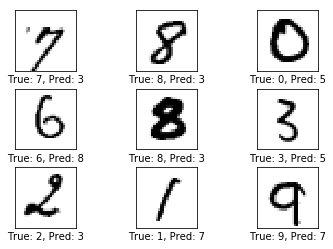

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

x_batch, y_batch = data.test.next_batch(9)
predictions = sess.run(pc, {x:x_batch, y:y_batch})
plot_images(x_batch, y_batch.argmax(1), predictions)

# Set up the net for evaluation

In [11]:
with tf.name_scope('accuracy'):
    correct = tf.equal(ec, pc, name='correct')  # for each sample, did we get it right? 
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='acc')

    # Create a node to save the accuracy to a log file, 
    # so that we can go back and see how it improves after training. 
    tf.summary.scalar('accuracy', accuracy);

In [12]:
# Normally, we would need to break the test data up into mini-batches.
# however, this set is small enough that we will send the entire 
# test set in as one large batch. 
print("Accuracy: {}".format(sess.run(accuracy, {x:data.test.images, y:data.test.labels})))
print("Random chance is around 0.10 (10%)")

Accuracy: 0.08969999849796295
Random chance is around 0.10 (10%)


# Save the log/summary data

Before we start training, let's look at the log data. 

*NOTE:* All log files will accumulate in the folder unless you delete them, or switch to a different log folder. If you are running this many times and adjusting settings, it is a good idea to think about how to choose differently named log folders for output. 

In [13]:
!mkdir -p ./log/run0

In [14]:
# Collect all of the 'summary' nodes from the graph and generate a single log entry from them. 
summary = tf.summary.merge_all()

In [15]:
# A utility to save summarys to the log directory. 
#  -- This will create a file, each time we add a summary to the writer it gets appended to a log file.
summary_writer = tf.summary.FileWriter('./log/run0', graph=sess.graph)

In [16]:
acc, log =  sess.run([accuracy, summary],
                     {x:data.test.images, y:data.test.labels})
summary_writer.add_summary(log, 0)

In order to train the net, we need to define an objective function to minimize. In this case we will use the cross-entropy loss because our output it a softmax classification. 

In [17]:
from pipes import quote
print("Acuracy:".format(acc))
print()
print("Make sure the correct conda environment is active, then run:")
print("    tensorboard --logdir={} ".format(quote(os.path.abspath('./log'))))
print("and open")
print("    http://localhost:6006/")
print("using your web browser")

Acuracy:

Make sure the correct conda environment is active, then run:
    tensorboard --logdir=/home/justin/cse627a/log 
and open
    http://localhost:6006/
using your web browser


# Set up the graph for training

In [18]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=a)
    loss = tf.reduce_mean(cross_entropy, name='loss')

    # And define a node to log it
    tf.summary.scalar('loss', loss);

In [19]:
with tf.name_scope('solver'):
    solver = tf.train.AdamOptimizer()
    optimize = solver.minimize(loss)

In [20]:
summary_writer = tf.summary.FileWriter('./log/run1/', graph=sess.graph)

In [21]:
# The solver has some parameters that need to be initializes
sess.run(tf.global_variables_initializer())

In [22]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [23]:
 # Training cycle
batch_size=100
training_epochs=20
display_epoch=1

try:
    saver.restore(sess, './models/logreg.cpt')
except:
    print("No model to restore")

for epoch in range(training_epochs):
    avg_loss = 0.
    total_batch = int(data.train.num_examples/batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = data.train.next_batch(batch_size)
       
        _, loss_, summary_ = sess.run([optimize, loss, summary],
                                    {x: batch_xs, y: batch_ys})
        
        global_iteration =  epoch * total_batch + i
        summary_writer.add_summary(summary_, global_iteration)
        
        avg_loss += loss_ / total_batch
        
    # Display logs per epoch step
    if (epoch+1) % display_epoch == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_loss))
    
    saver.save(sess, './models/logreg.cpt')

INFO:tensorflow:Restoring parameters from ./models/logreg.cpt
No model to restore
Epoch: 0001 cost= 4.720562264
Epoch: 0002 cost= 1.371919554
Epoch: 0003 cost= 0.944586730
Epoch: 0004 cost= 0.760865335
Epoch: 0005 cost= 0.652589689
Epoch: 0006 cost= 0.581364032
Epoch: 0007 cost= 0.530487438
Epoch: 0008 cost= 0.491582816
Epoch: 0009 cost= 0.462384792
Epoch: 0010 cost= 0.438551794
Epoch: 0011 cost= 0.419319306
Epoch: 0012 cost= 0.403087353
Epoch: 0013 cost= 0.389303462
Epoch: 0014 cost= 0.377467859
Epoch: 0015 cost= 0.367368911
Epoch: 0016 cost= 0.357773887
Epoch: 0017 cost= 0.349654566
Epoch: 0018 cost= 0.342827139
Epoch: 0019 cost= 0.335817871
Epoch: 0020 cost= 0.329968826


# Exercise: Add a hidden layer (Solution)

Let's go back and add a hidden layer. In addition to adding a hidden layer, we will also periodically check our model with the validation set and log the data. This gives a way to determine how well our model will generalize. Adding validation results to the summaries will require a few changes in how the summaries are built.

First, since we are adding a hidden layer, we will have another parameter to tune our nerual network. This is the number of nodes in the hidden layer. For now we will set this to 1000, but this could be adjusted later.

In [24]:
#hyperparameters
hidden_layer_size = 1000

In [25]:
# Clear the current graph so that we can build a new graph
tf.reset_default_graph()

First we define the input layer. This is the same as before.

In [26]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, 28*28), name='x')
    y = tf.placeholder(tf.float32, (None, 10), name='y')
    ec = tf.argmax(y, 1, name='ec')
  
    tf.summary.image("image", tf.reshape(x, [-1, 28,28,1]), max_outputs=3)

Now we build our hidden layer. This layer will take the input, multiply by the weight tensor, and add a bias. That is:
$$ \mathbf{h_1} = f(\mathbf{W}\mathbf{x} + \mathbf{b}) $$
where $\mathbf{x}$ is the input tensor, $\mathbf{W}$ is the weights, $\mathbf{b}$ is the bias, and $f$ is our activation function. Note that we have $\mathbf{x}\mathbf{W}$ in the code because of the shape of the input.

For the activation function, we will use a rectified linear unit (ReLU). ReLU is mathematically defined as:
$$f(x)=max(0,x)$$
ReLU has several advantages over other activation functions, including both efficient computation and efficient gradient propagation.

For the output layer, we do the same as before but use the output of the hidden layer as input.

In [27]:
with tf.name_scope('hidden_layer'):
    b1 = tf.Variable(tf.zeros(hidden_layer_size), name='b1')
    W1 = tf.Variable(tf.truncated_normal([num_inputs, hidden_layer_size]), name='W')
    preactivations = tf.add(tf.matmul(x, W1), b1, name='preactivations')
    activations = tf.nn.relu(preactivations, name='activations')
    
    # Hidden layer summaries
    tf.summary.histogram("weights_hidden_layer", W1)
    tf.summary.histogram("biases_hidden_layer", b1)

with tf.name_scope('output'):
    b2 = tf.Variable(tf.zeros(num_outputs), name='b2')
    W2 = tf.Variable(tf.truncated_normal([hidden_layer_size, num_outputs]), name='W1')
    logits = tf.add(tf.matmul(activations, W2), b2, name='logits')
    
    z = tf.nn.softmax(logits, name='z')
    pc = tf.argmax(z, 1, name='pc')
    
    # output layer summaries
    tf.summary.histogram("weights_output", W2)
    tf.summary.histogram("biases_output", b2)
    
# Merge all the summaries we have made so far.
network_summary = tf.summary.merge_all()

Now we create the nodes that calculate the loss and accuracy. Our solver is the same as before. Notice that we have two seperate summaries for the training and validation. This is because if we use the same summary, both training and validation data will be added to the same graph, which is undesirable.

In [28]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(cross_entropy, name='loss')

    # Create nodes to log training and validation log loss.
    training_loss_summary = tf.summary.scalar('training_loss', loss)
    validation_loss_summary = tf.summary.scalar('validation_loss', loss)
    
with tf.name_scope('solver'):
    solver = tf.train.AdamOptimizer()
    optimize = solver.minimize(loss)
    
with tf.name_scope('accuracy'):
    correct = tf.equal(ec, pc, name='correct')
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='acc')

    # Create nodes to log training and validation accuracy.
    training_accuracy_summary = tf.summary.scalar("training_accuracy", accuracy)
    validation_accuracy_summary = tf.summary.scalar("validation_accuracy", accuracy)

Create the two seperate summaries. train_summary logs weight data, sample images, along with the accuracy and log loss. validation_summary just keeps track of the validation accuracy and log loss.

In [29]:
train_summary = tf.summary.merge([training_loss_summary, training_accuracy_summary, network_summary])
validation_summary = tf.summary.merge([validation_loss_summary, validation_accuracy_summary])

In [30]:
# Training cycle
batch_size=100
training_epochs=20
display_epoch=1 # also determines when to run the validation set.

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

summary_writer = tf.summary.FileWriter('./log/run2/', graph=sess.graph)

saver = tf.train.Saver()
try:
    saver.restore(sess, './models/logreg2.cpt')
except:
    print("No model to restore")

INFO:tensorflow:Restoring parameters from ./models/logreg2.cpt
No model to restore


Finally, we train the model. This is the same as before, except we use our new summary nodes. Note that this takes a while to train.

In [31]:
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_accuracy = 0.
    total_batch = int(data.train.num_examples/batch_size)
    
    for i in range(total_batch):
        batch_xs, batch_ys = data.train.next_batch(batch_size)
       
        _, loss_, accuracy_, training_summary_ = sess.run(
                        [optimize, loss, accuracy, train_summary],
                        {x: batch_xs, y: batch_ys})
        
        global_iteration =  epoch * total_batch + i
        summary_writer.add_summary(training_summary_, global_iteration)
        
        avg_loss += loss_ / total_batch
        avg_accuracy += accuracy_ / total_batch
        
    # Display logs per epoch step. Also runs the model through the validation data
    if (epoch+1) % display_epoch == 0:
        # Print training results
        print("Epoch:", '%04d' % (epoch+1), "train loss=", "{:.4f}".format(avg_loss),end=' ')
        print("train acc=", "{:.4f}".format(avg_accuracy),end=' ')
        
        # Also print and record validation results
        xs, ys = data.validation.next_batch(data.validation.num_examples)
        
        # IMPORTANT: Do not run the optimize node here, as training the model with
        # validation data would defeat the purpose of holding out data.
        loss_, accuracy_, validation_summary_ = sess.run(
                        [loss, accuracy, validation_summary],
                        {x: xs, y: ys})
        
        global_iteration = epoch
        summary_writer.add_summary(validation_summary_, global_iteration)
        print('val loss= {:.4f}'.format(loss_),end=' ')
        print('val acc= {:.4f}'.format(accuracy_))
    
    saver.save(sess, './models/logreg2.cpt')

Epoch: 0001 train loss= 18.8901 train acc= 0.7841 val loss= 6.2379 val acc= 0.8972
Epoch: 0002 train loss= 4.8123 train acc= 0.9107 val loss= 3.8810 val acc= 0.9272
Epoch: 0003 train loss= 2.9480 train acc= 0.9356 val loss= 3.2596 val acc= 0.9350
Epoch: 0004 train loss= 1.9939 train acc= 0.9493 val loss= 2.9646 val acc= 0.9370
Epoch: 0005 train loss= 1.3602 train acc= 0.9602 val loss= 2.4540 val acc= 0.9454
Epoch: 0006 train loss= 0.9672 train acc= 0.9671 val loss= 2.2819 val acc= 0.9488
Epoch: 0007 train loss= 0.6630 train acc= 0.9738 val loss= 2.1251 val acc= 0.9512
Epoch: 0008 train loss= 0.4678 train acc= 0.9781 val loss= 2.0300 val acc= 0.9536
Epoch: 0009 train loss= 0.3393 train acc= 0.9826 val loss= 2.0764 val acc= 0.9532
Epoch: 0010 train loss= 0.2757 train acc= 0.9847 val loss= 1.9710 val acc= 0.9568
Epoch: 0011 train loss= 0.2257 train acc= 0.9869 val loss= 1.8517 val acc= 0.9584
Epoch: 0012 train loss= 0.1702 train acc= 0.9889 val loss= 1.8606 val acc= 0.9548
Epoch: 0013 tra